In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from itertools import product as product
from math import ceil

def generate_anchors():
    # 320x230
    #min_sizes_org = [[8, 11], [14, 19, 26, 38, 64, 149]]
    # 128 x128
    min_sizes_org = [[16, 24], [32, 48, 64, 80, 96, 128]]
    steps = [8, 16]
    #clip = False
    feature_maps = [[ceil(input_h/step), ceil(input_w/step)] for step in steps]
    #print("feature_maps: ", feature_maps)

    anchors = []
    for k, f in enumerate(feature_maps):
        min_sizes = min_sizes_org[k]
        #print(k, f)
        #print(f"{f[0]}, {f[1]}")
        #print(f"product len: ", product(range(f[0]), range(f[1])))
        for i, j in product(range(f[0]), range(f[1])):
            #print(i, j)
            #print(f"min sizes len: ", min_sizes)
            for min_size in min_sizes:
                s_kx = min_size / input_w
                s_ky = min_size / input_h
                #print(f"(s_kx, s_ky): {s_kx, s_ky})")
                dense_cx = [x * steps[k] / input_w for x in [j + 0.5]]
                dense_cy = [y * steps[k] / input_h for y in [i + 0.5]]
                #print(dense_cx, dense_cy)
                for cy, cx in product(dense_cy, dense_cx):
                    anchors += [cx, cy, s_kx, s_ky]
    # back to torch land
    #output = torch.Tensor(anchors).view(-1, 4)
    anchors = np.reshape(anchors, (-1, 4))
    print("anchors: ", anchors.shape)
    # if clip:
    #     output.clamp_(max=1, min=0)
    np.savetxt("anchors_128x128.txt", anchors, delimiter=",")
    return anchors

def py_cpu_nms(dets, thresh):
    """Pure Python NMS baseline."""
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

# Load the TFLite model and allocate tensors.
#interpreter = tf.lite.Interpreter(model_path="weights/20230703/Blaze_Final_320.tflite")
interpreter = tf.lite.Interpreter(model_path="weights/20230823/Blaze_Final.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
print("input_details: ", input_details)
(input_w, input_h) = input_details[0]['shape'][2:]
print("image size: ", (input_w, input_h))
output_details = interpreter.get_output_details()
print("output_details: ", output_details)

2023-08-24 10:51:00.343766: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


input_details:  [{'name': 'serving_default_Input:0', 'index': 0, 'shape': array([  1,   3, 128, 128], dtype=int32), 'shape_signature': array([  1,   3, 128, 128], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
image size:  (128, 128)
output_details:  [{'name': 'PartitionedCall:0', 'index': 234, 'shape': array([  1, 896,   2], dtype=int32), 'shape_signature': array([  1, 896,   2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'PartitionedCall:2', 'index': 231, 'shape': array([  1, 896,   4], dtype=int32), 'shape_signature': array([  1, 896,   4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [2]:
image_path = "images/test2.jpg"
img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
org_h, org_w, _ = img_raw.shape
input_data = cv2.resize(img_raw, (input_w, input_h), interpolation=cv2.INTER_LINEAR)
input_data = np.float32(input_data)
input_data -= (104, 117, 123)
input_data = input_data.transpose(2, 0, 1)
input_data = np.expand_dims(input_data, axis=0)
print("input shape: ", input_data.shape)

input shape:  (1, 3, 128, 128)


In [3]:
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
conf = interpreter.get_tensor(output_details[0]['index'])
print("conf: ", conf.shape)
loc = interpreter.get_tensor(output_details[1]['index'])
print("loc: ", loc.shape)
landms = interpreter.get_tensor(output_details[2]['index'])
print("landms: ", landms.shape)

conf:  (1, 896, 2)
loc:  (1, 896, 4)
landms:  (1, 896, 4)


In [4]:
variances = [0.1, 0.2]
scale = np.array([img_raw.shape[1], img_raw.shape[0], img_raw.shape[1], img_raw.shape[0]])
#scale = np.array([input_h, input_h, input_h, input_h])
print("scale: ", scale)
anchors = generate_anchors()
#anchors = np.load("anchors_320x320.npy")

loc = loc.squeeze(0)
boxes = np.concatenate((anchors[:, :2] + loc[:, :2] * variances[0] * anchors[:, 2:],
                        anchors[:, 2:] * np.exp(loc[:, 2:] * variances[1])), 1)
boxes[:, :2] -= boxes[:, 2:] / 2
boxes[:, 2:] += boxes[:, :2]
#boxes = boxes * scale
#boxes = boxes.cpu().numpy()
#print("boxes: ", boxes)

landms = landms.squeeze(0)
landms = np.concatenate((anchors[:, :2] + landms[:, :2] * variances[0] * anchors[:, 2:],
                        anchors[:, :2] + landms[:, 2:4] * variances[0] * anchors[:, 2:],
                        ), 1)
landms = landms * scale

scores = conf.squeeze(0)[:, 1]
# ignore low scores
inds = np.where(scores > 0.7)[0]
print("inds: ", inds.shape)
scores = scores[inds]
boxes = boxes[inds]
# print("boxes: ", boxes)
# boxes = boxes * scale
# print("boxes scaled: ", boxes)
landms = landms[inds]

# keep top-K before NMS
order = scores.argsort()[::-1][:2000]
scores = scores[order]
boxes = boxes[order]
landms = landms[order]

# do NMS
dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
keep = py_cpu_nms(dets, 0.1)
dets = dets[keep, :]
landms = landms[keep]

# keep top-K faster NMS
dets = dets[:1000, :]
landms = landms[:1000, :]

scale:  [800 600 800 600]
anchors:  (896, 4)
inds:  (11,)


image shape:  (1920, 1080, 3)
bbox raw:  [0.30540872 0.18829021 0.69148701 0.53542191]
329 361 746 1028


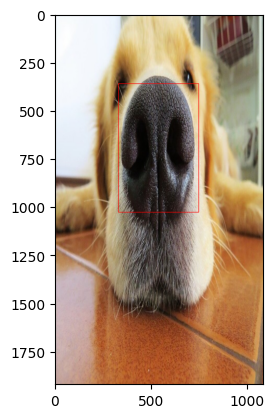

In [5]:
img_show = cv2.imread(image_path, cv2.IMREAD_COLOR)
org_w, org_h = (1080, 1920)
img_show = cv2.resize(img_show, (org_w, org_h), interpolation=cv2.INTER_LINEAR)
print("image shape: ", img_show.shape)
dets = np.concatenate((dets, landms), axis=1)
for b in dets:
    # if b[4] < 0.3:
    #     continue
    # b = list(map(int, b))
    print("bbox raw: ", b[:4])
    cv2.rectangle(img_show, (int(b[0]*org_w), int(b[1]*org_h)), (int(b[2]*org_w), int(b[3]*org_h)), (0, 0, 255), 2)
    #cv2.rectangle(img_show, (329, 305), (771, 1013), (0, 0, 255), 2)
    print(int(b[0]*org_w), int(b[1]*org_h), int(b[2]*org_w), int(b[3]*org_h))
    #text = "{:.4f}".format(b[4])
    #print("confidence: ", text)
    # cx = b[0]
    # cy = b[1] + 12
    # cv2.putText(img_raw, text, (cx, cy), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
    # landms
    # cv2.circle(img_show, (b[5], b[6]), 1, (0, 255, 0), 4)
    # cv2.circle(img_show, (b[7], b[8]), 1, (0, 255, 0), 4)
#cv2.imwrite('result1.jpg', img_raw)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()